In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

df = pd.read_csv("cleaned_dogs_data.csv")

* __[Usefull functions](#Usefull-functions)__
    * [Data preparation functions](#Data-preparation-functions)
    * [Model performance functions](#Model-performance-functions)
* __[All categories ML](#All-categories-ML)__
    * [Logistic Regression](#Logistic-Regression)
    * [Naive Bayes](#Naive-Bayes)
    * [SVM](#SVM)
    * [Random Forest](#Random-Forest)
    * [XGBoost](#XGBoost)
* __[Without Mixed Breed Dogs ML](#Without-Mixed-Breed-Dogs-ML)__
    * [Logistic Regression without Mixed Breed Dogs](#Logistic-Regression-without-Mixed-Breed-Dogs)
    * [Naive Bayes without Mixed Breed Dogs](#Naive-Bayes-without-Mixed-Breed-Dogs)
    * [SVM without Mixed Breed Dogs](#SVM-without-Mixed-Breed-Dogs)
    * [Random Forest without Mixed Breed Dogs](#Random-Forest-without-Mixed-Breed-Dogs)
    * [XGBoost without Mixed Breed Dogs](#XGBoost-without-Mixed-Breed-Dogs)

# Usefull functions

## Data preparation functions

In [12]:
def split_dataframe(df):
    X = df[df.columns.difference(['name', 'Dog Breed Group'])]
    y = df['Dog Breed Group']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
    return X_train, X_test, y_train, y_test


def impute_dataset(X_train, X_test):
    numeric_columns = ['Min Life Expectancy', 'Max Life Expectancy', 'Min Height',
                       'Max Height', 'Min Weight', 'Max Weight']
    category_columns = X_train.columns.difference(numeric_columns)
    
    numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    numeric_X_train = numeric_imputer.fit_transform(X_train[numeric_columns])
    numeric_X_test = numeric_imputer.transform(X_test[numeric_columns])

    category_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    category_X_train = category_imputer.fit_transform(X_train[category_columns])
    category_X_test = category_imputer.transform(X_test[category_columns])

    imputed_X_train = pd.concat([pd.DataFrame(category_X_train, columns=category_columns),
                                 pd.DataFrame(numeric_X_train, columns=numeric_columns)], axis=1)
    imputed_X_test = pd.concat([pd.DataFrame(category_X_test, columns=category_columns),
                                pd.DataFrame(numeric_X_test, columns=numeric_columns)], axis=1)
    
    return imputed_X_train, imputed_X_test


def scale_dataset(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)

    scaled_X_train_np = scaler.transform(X_train)
    scaled_X_test_np = scaler.transform(X_test)

    scaled_X_train = pd.DataFrame(scaled_X_train_np, columns=X_train.columns)
    scaled_X_test = pd.DataFrame(scaled_X_test_np, columns=X_test.columns)
    
    return scaled_X_train, scaled_X_test


def select_features(X_train, X_test, y_train, k):
    select_k_best = SelectKBest(f_classif, k=k)

    selected_X_train_np = select_k_best.fit_transform(X_train, y_train)
    selected_X_test_np = select_k_best.transform(X_test)

    selected_columns = select_k_best.get_feature_names_out()
    selected_X_train = pd.DataFrame(selected_X_train_np, columns=selected_columns)
    selected_X_test = pd.DataFrame(selected_X_test_np, columns=selected_columns)
    
    return selected_X_train, selected_X_test


def prepare_data(df, scaling=False, k=20):
    # train test split
    X_train, X_test, y_train, y_test = split_dataframe(df)
    
    # imputation
    X_train, X_test = impute_dataset(X_train, X_test)
    
    # scaling
    if scaling:
        X_train, X_test = scale_dataset(X_train, X_test)
        
    # feature selection
    X_train, X_test = select_features(X_train, X_test, y_train, k=k)
    
    return X_train, X_test, y_train, y_test
    
    

## Model performance functions

In [13]:
def show_model_performance(model, params, X_train, y_train, X_test, y_test):
    clf = GridSearchCV(model, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=4)
    clf.fit(X_train, y_train)
    best_model = clf.best_estimator_
    
    print("====== BEST MODEL PARAMS ======")
    print(f"Best_score: {clf.best_score_}")
    for param in clf.best_params_.items():
        print(param)
    
    print("====== TEST DATA PREDICTION ======")
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f"Score: {best_model.score(X_test, y_test)}")
    
    labels = sorted(list(set(y_test)))
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.show()
    
    return best_model


# All categories ML

In [14]:
X_train, X_test, y_train, y_test = prepare_data(df)
scaled_X_train, scaled_X_test, _, _ = prepare_data(df, scaling=True)

## Logistic regression

In [15]:
solvers_with_penalties = {'lbfgs': ['l2', 'none'],
                          'liblinear': ['l1', 'l2'],
                          'sag': ['l2', 'none'],
                          'saga': ['l1', 'l2', 'none']}


logistic_regression_params = [{
                              'penalty': penalties,
                              'C': [0.4, 0.45, 0.5, 0.6,],
                              'class_weight': ['balanced', None],
                              'solver': [solver]
                             } for solver, penalties in solvers_with_penalties.items()]

for x in logistic_regression_params:
    print(x)

{'penalty': ['l2', 'none'], 'C': [0.4, 0.45, 0.5, 0.6], 'class_weight': ['balanced', None], 'solver': ['lbfgs']}
{'penalty': ['l1', 'l2'], 'C': [0.4, 0.45, 0.5, 0.6], 'class_weight': ['balanced', None], 'solver': ['liblinear']}
{'penalty': ['l2', 'none'], 'C': [0.4, 0.45, 0.5, 0.6], 'class_weight': ['balanced', None], 'solver': ['sag']}
{'penalty': ['l1', 'l2', 'none'], 'C': [0.4, 0.45, 0.5, 0.6], 'class_weight': ['balanced', None], 'solver': ['saga']}
{'penalty': ['l2', 'none'], 'C': [0.4, 0.45, 0.5, 0.6], 'class_weight': ['balanced', None], 'solver': ['lbfgs']}
{'penalty': ['l1', 'l2'], 'C': [0.4, 0.45, 0.5, 0.6], 'class_weight': ['balanced', None], 'solver': ['liblinear']}
{'penalty': ['l2', 'none'], 'C': [0.4, 0.45, 0.5, 0.6], 'class_weight': ['balanced', None], 'solver': ['sag']}
{'penalty': ['l1', 'l2', 'none'], 'C': [0.4, 0.45, 0.5, 0.6], 'class_weight': ['balanced', None], 'solver': ['saga']}


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\wspyc\Desktop\Learning_stuff\Data_Science_projects\Project_with_Ken\IntroDSProject\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


====== BEST MODEL PARAMS ======
Best_score: 0.3765075397805995
('C', 0.45)
('class_weight', 'balanced')
('penalty', 'l2')
('solver', 'lbfgs')
====== TEST DATA PREDICTION ======
                  precision    recall  f1-score   support

  Companion Dogs       0.25      0.27      0.26        15
    Herding Dogs       0.33      0.42      0.37        12
      Hound Dogs       0.40      0.46      0.43        13
     Hybrid Dogs       0.14      0.50      0.22         4
Mixed Breed Dogs       0.67      0.27      0.39        44
   Sporting Dogs       0.37      0.54      0.44        13
    Terrier Dogs       0.37      0.70      0.48        10
    Working Dogs       0.69      0.52      0.59        21

        accuracy                           0.41       132
       macro avg       0.40      0.46      0.40       132
    weighted avg       0.50      0.41      0.42       132

Score: 0.4090909090909091


C:\Users\wspyc\Desktop\Learning_stuff\Data_Science_projects\Project_with_Ken\IntroDSProject\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


====== BEST MODEL PARAMS ======
Best_score: 0.3765075397805995
('C', 0.45)
('class_weight', 'balanced')
('penalty', 'l2')
('solver', 'lbfgs')
====== TEST DATA PREDICTION ======
                  precision    recall  f1-score   support

  Companion Dogs       0.25      0.27      0.26        15
    Herding Dogs       0.33      0.42      0.37        12
      Hound Dogs       0.40      0.46      0.43        13
     Hybrid Dogs       0.14      0.50      0.22         4
Mixed Breed Dogs       0.67      0.27      0.39        44
   Sporting Dogs       0.37      0.54      0.44        13
    Terrier Dogs       0.37      0.70      0.48        10
    Working Dogs       0.69      0.52      0.59        21

        accuracy                           0.41       132
       macro avg       0.40      0.46      0.40       132
    weighted avg       0.50      0.41      0.42       132

Score: 0.4090909090909091


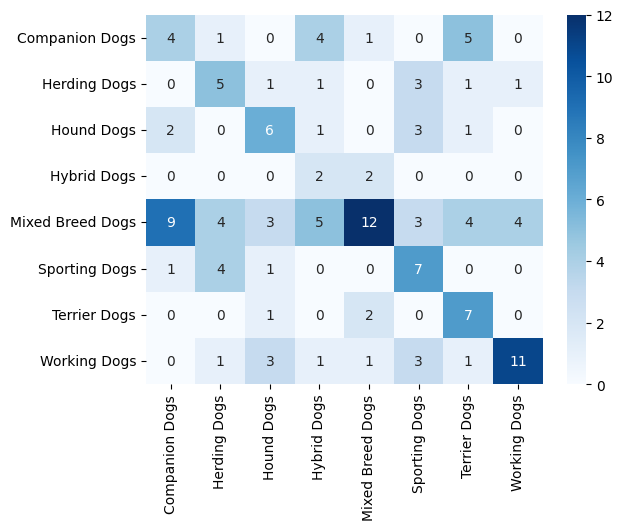

LogisticRegression(C=0.45, class_weight='balanced', random_state=42)

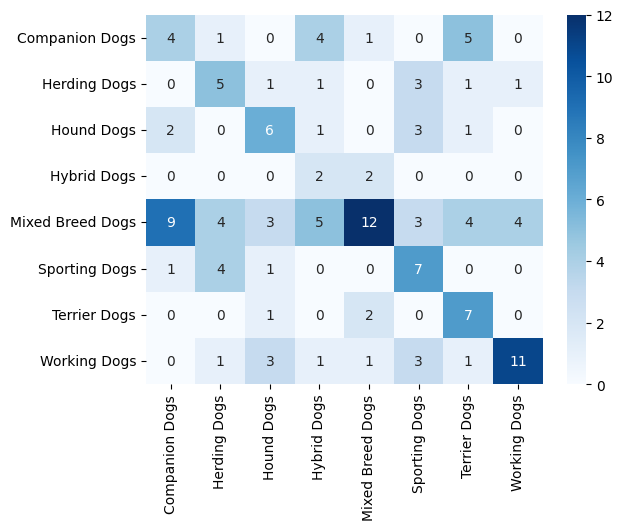

LogisticRegression(C=0.45, class_weight='balanced', random_state=42)

In [16]:
logistic_regression_model = LogisticRegression(random_state=RANDOM_STATE)
show_model_performance(logistic_regression_model, logistic_regression_params, X_train, y_train, X_test, y_test)

## Naive Bayes

Fitting 3 folds for each of 7 candidates, totalling 21 fits
====== BEST MODEL PARAMS ======
Best_score: 0.2977872470504825
('var_smoothing', 1e-10)
====== TEST DATA PREDICTION ======
                  precision    recall  f1-score   support

  Companion Dogs       0.40      0.67      0.50        15
    Herding Dogs       0.27      0.25      0.26        12
      Hound Dogs       0.46      0.46      0.46        13
     Hybrid Dogs       0.00      0.00      0.00         4
Mixed Breed Dogs       0.50      0.16      0.24        44
   Sporting Dogs       0.33      0.62      0.43        13
    Terrier Dogs       0.27      0.60      0.37        10
    Working Dogs       0.60      0.57      0.59        21

        accuracy                           0.39       132
       macro avg       0.36      0.42      0.36       132
    weighted avg       0.43      0.39      0.37       132

Score: 0.3939393939393939
Fitting 3 folds for each of 7 candidates, totalling 21 fits
====== BEST MODEL PARAMS ======


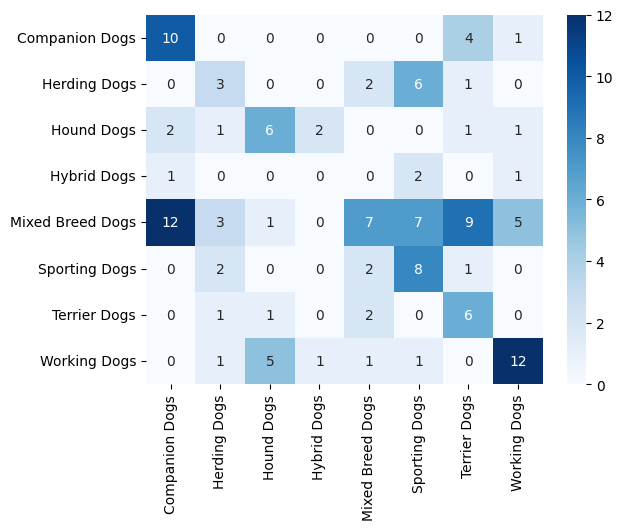

GaussianNB(var_smoothing=1e-10)

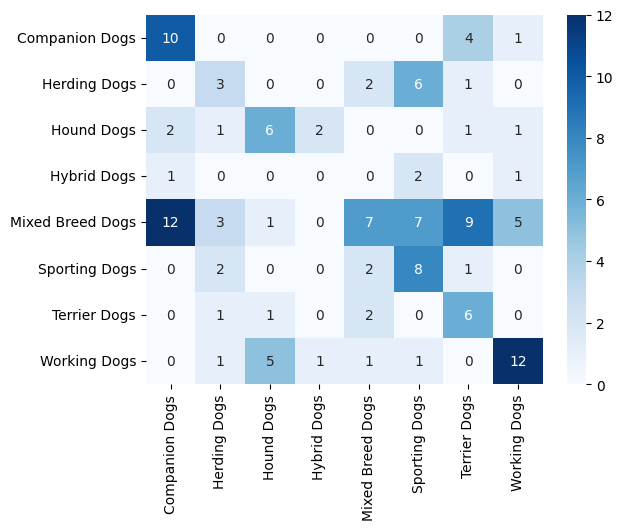

GaussianNB(var_smoothing=1e-10)

In [17]:
gaussian_nb_model = GaussianNB()
gaussian_nb_params = {'var_smoothing': [1e-10, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1]}

show_model_performance(gaussian_nb_model, gaussian_nb_params, X_train, y_train, X_test, y_test)

## SVC

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits
Fitting 3 folds for each of 2592 candidates, totalling 7776 fits
====== BEST MODEL PARAMS ======
Best_score: 0.36529479091049116
('C', 1.5)
('class_weight', 'balanced')
('coef0', 0.5)
('degree', 2)
('gamma', 'scale')
('kernel', 'poly')
('shrinking', True)
('tol', 0.0001)
====== TEST DATA PREDICTION ======
                  precision    recall  f1-score   support

  Companion Dogs       0.39      0.60      0.47        15
    Herding Dogs       0.20      0.25      0.22        12
      Hound Dogs       0.35      0.46      0.40        13
     Hybrid Dogs       0.00      0.00      0.00         4
Mixed Breed Dogs       0.67      0.36      0.47        44
   Sporting Dogs       0.42      0.38      0.40        13
    Terrier Dogs       0.35      0.60      0.44        10
    Working Dogs       0.61      0.52      0.56        21

        accuracy                           0.42       132
       macro avg       0.37      0.40      0.3

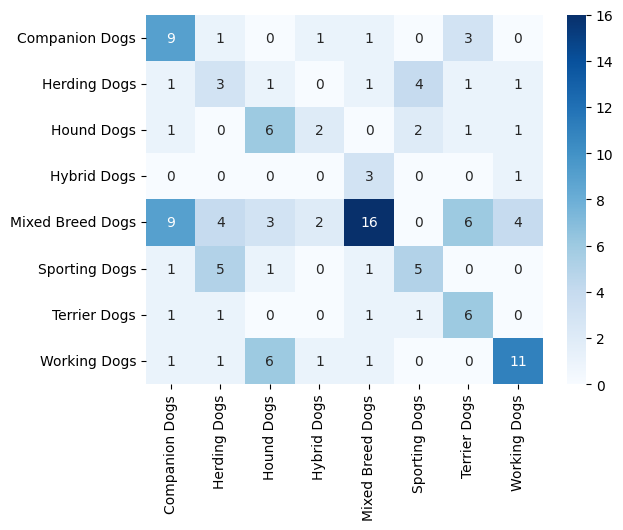

SVC(C=1.5, class_weight='balanced', coef0=0.5, degree=2, kernel='poly',
    random_state=42, tol=0.0001)

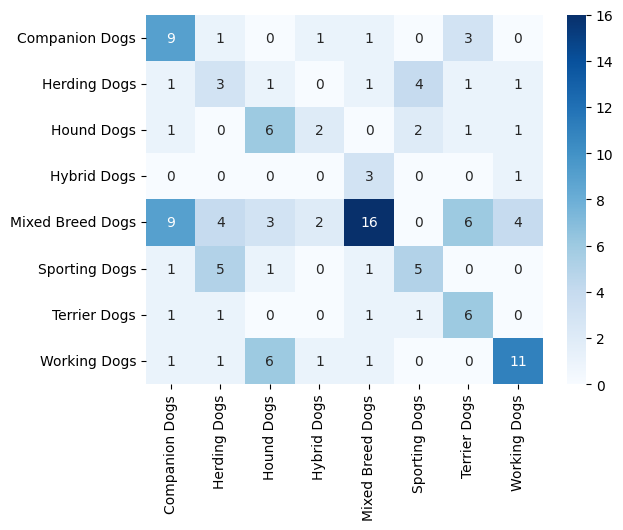

SVC(C=1.5, class_weight='balanced', coef0=0.5, degree=2, kernel='poly',
    random_state=42, tol=0.0001)

In [18]:
svm_model = SVC(random_state=RANDOM_STATE)
svm_params = {
              'C': [0.5, 1, 1.5],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [1, 2, 3],
              'gamma': ['auto', 'scale'],
              'coef0': [0.05, 0.1, 0.5],
              'tol': [1e-4, 1e-3, 1e-2],
              'shrinking': [True, False],
              'class_weight': ['balanced', None],
             }

show_model_performance(svm_model, svm_params, scaled_X_train, y_train, scaled_X_test, y_test)

## Random Forest

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
====== BEST MODEL PARAMS ======
Best_score: 0.38527622771294917
('class_weight', None)
('criterion', 'gini')
('n_estimators', 200)
====== TEST DATA PREDICTION ======
                  precision    recall  f1-score   support

  Companion Dogs       0.70      0.47      0.56        15
    Herding Dogs       0.27      0.25      0.26        12
      Hound Dogs       0.50      0.31      0.38        13
     Hybrid Dogs       0.00      0.00      0.00         4
Mixed Breed Dogs       0.55      0.77      0.64        44
   Sporting Dogs       0.50      0.38      0.43        13
    Terrier Dogs       0.75      0.60      0.67        10
    Working Dogs       0.57      0.62      0.59        21

        accuracy                           0.55       132
       macro avg       0.48      0.43      0.44       132
    weighted avg       0.53      0.55      0.53       132

Score: 0.5454

C:\Users\wspyc\Desktop\Learning_stuff\Data_Science_projects\Project_with_Ken\IntroDSProject\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wspyc\Desktop\Learning_stuff\Data_Science_projects\Project_with_Ken\IntroDSProject\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wspyc\Desktop\Learning_stuff\Data_Science_projects\Project_with_Ken\IntroDSProject\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in

====== BEST MODEL PARAMS ======
Best_score: 0.38527622771294917
('class_weight', None)
('criterion', 'gini')
('n_estimators', 200)
====== TEST DATA PREDICTION ======
                  precision    recall  f1-score   support

  Companion Dogs       0.70      0.47      0.56        15
    Herding Dogs       0.27      0.25      0.26        12
      Hound Dogs       0.50      0.31      0.38        13
     Hybrid Dogs       0.00      0.00      0.00         4
Mixed Breed Dogs       0.55      0.77      0.64        44
   Sporting Dogs       0.50      0.38      0.43        13
    Terrier Dogs       0.75      0.60      0.67        10
    Working Dogs       0.57      0.62      0.59        21

        accuracy                           0.55       132
       macro avg       0.48      0.43      0.44       132
    weighted avg       0.53      0.55      0.53       132

Score: 0.5454545454545454


C:\Users\wspyc\Desktop\Learning_stuff\Data_Science_projects\Project_with_Ken\IntroDSProject\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wspyc\Desktop\Learning_stuff\Data_Science_projects\Project_with_Ken\IntroDSProject\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wspyc\Desktop\Learning_stuff\Data_Science_projects\Project_with_Ken\IntroDSProject\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in

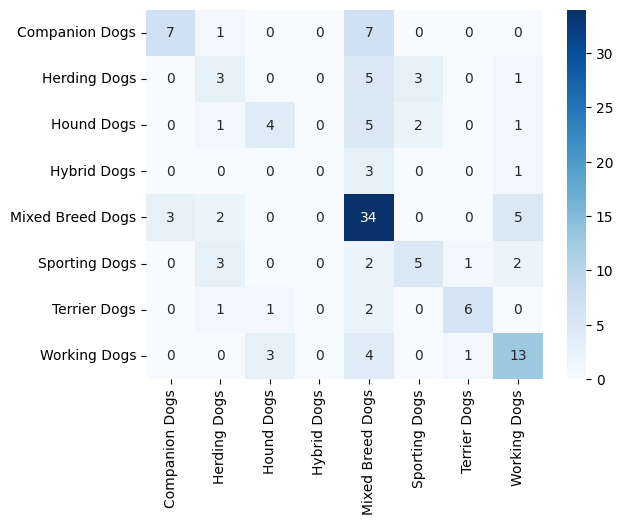

RandomForestClassifier(n_estimators=200, random_state=42)

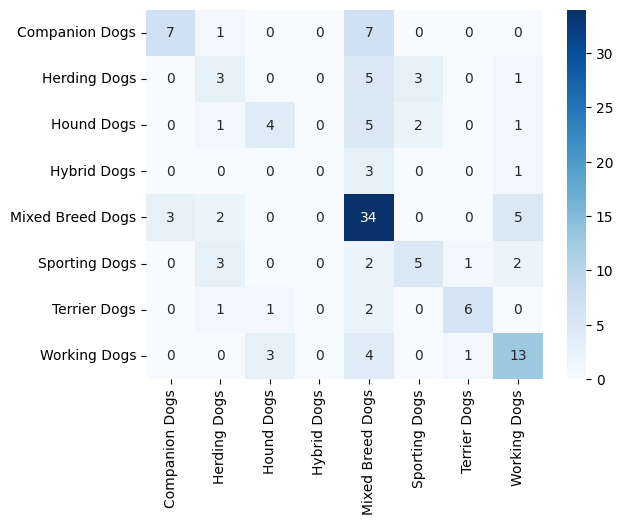

RandomForestClassifier(n_estimators=200, random_state=42)

In [19]:
rdf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rdf_params = {
              'n_estimators': [100, 200],
              'criterion': ['gini', 'entropy'],
              'class_weight': ['balanced', 'balanced_subsample', None]
             }
show_model_performance(rdf_model, rdf_params, X_train, y_train, X_test, y_test)

## XGBoost

In [21]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

xgb_model = xgb.XGBClassifier(random_state=RANDOM_STATE)

xgb_params = {'n_estimators': [50, 100, 200],
              'grow_policy': ['depthwise', 'lossguide'],
              'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
              'booster': ['gbtree', 'gblinear', 'dart']
}

show_model_performance(xgb_model, xgb_params, X_train, encoded_y_train, X_test, encoded_y_test)

AttributeError: module 'xgboost' has no attribute 'XGBClassifier'

AttributeError: module 'xgboost' has no attribute 'XGBClassifier'

# Without Mixed Breed Dogs ML

In [ ]:
df_wo_mbd = df[df['Dog Breed Group'] != 'Mixed Breed Dogs']

X_train_wo_mbd, X_test_wo_mbd, y_train_wo_mbd, y_test_wo_mbd = prepare_data(df_wo_mbd)
scaled_X_train_wo_mbd, scaled_X_test_wo_mbd, _, _ = prepare_data(df_wo_mbd, scaling=True)

## Logistic Regression without Mixed Breed Dogs

In [ ]:
logistic_regression_model_wo_mbd = LogisticRegression(random_state=RANDOM_STATE)
show_model_performance(logistic_regression_model_wo_mbd, logistic_regression_params,
                       X_train_wo_mbd, y_train_wo_mbd, X_test_wo_mbd, y_test_wo_mbd)

## Naive Bayes without Mixed Breed Dogs

In [ ]:
gaussian_nb_model_wo_mbd = GaussianNB()
show_model_performance(gaussian_nb_model_wo_mbd, gaussian_nb_params, X_train_wo_mbd, y_train_wo_mbd,
                       X_test_wo_mbd, y_test_wo_mbd)

## SVC without Mixed Breed Dogs

In [ ]:
svm_model_wo_mbd = SVC(random_state=RANDOM_STATE)
show_model_performance(svm_model_wo_mbd, svm_params, scaled_X_train_wo_mbd, y_train_wo_mbd,
                       scaled_X_test_wo_mbd, y_test_wo_mbd)

## Random Forest without Mixed Breed Dogs

In [ ]:
rdf_model_wo_mbd = RandomForestClassifier(random_state=RANDOM_STATE)
show_model_performance(rdf_model_wo_mbd, rdf_params, X_train_wo_mbd, y_train_wo_mbd, X_test_wo_mbd, y_test_wo_mbd)

## XGBoost without Mixed Breed Dogs

In [ ]:
label_encoder_wo_mbd = LabelEncoder()
encoded_y_train_wo_mbd = label_encoder.fit_transform(y_train_wo_mbd)
encoded_y_test_wo_mbd = label_encoder.fit_transform(y_test_wo_mbd)

xgb_model_wo_mbd = xgb.XGBClassifier(random_state=RANDOM_STATE)
show_model_performance(xgb_model_wo_mbd, xgb_params, X_train_wo_mbd, encoded_y_train_wo_mbd,
                       X_test_wo_mbd, encoded_y_test_wo_mbd)

# Conclusion

Even without "Mixed Breed Dogs" category, models performances are too poor to put one of them into app. Problem of this project is data. Dataset should be larger a lot and the features should be more informative (classifying dogs on their temperament and other attributes not connected with apperance is pretty abstract idea). 